## 3.4 降维、特征提取与流形学习
利用无监督学习进行数据变换最常见的目的就是可视化、压缩数据、以及寻找信息量更大的数据表示以用于进一步的处理。为了实现这些目的，最简单也最常用的一种算法就是主成分分析。我们也将学习另外两种算法：非负矩阵分解(NMF)和t-SNE，前者通常用于特征提取，后者通常用于二维散点图的可视化。

### 3.4.1 主成分分析
主成分分析(principal component analysis，PCA)是一种旋转数据集的方法，旋转后的特征在统计上不相关。在做完这种旋转之后，通常是根据新特征对解释数据的重要性来选择它的一个子集。下面的例子展示了PCA对一个模拟二维数据集的作用：

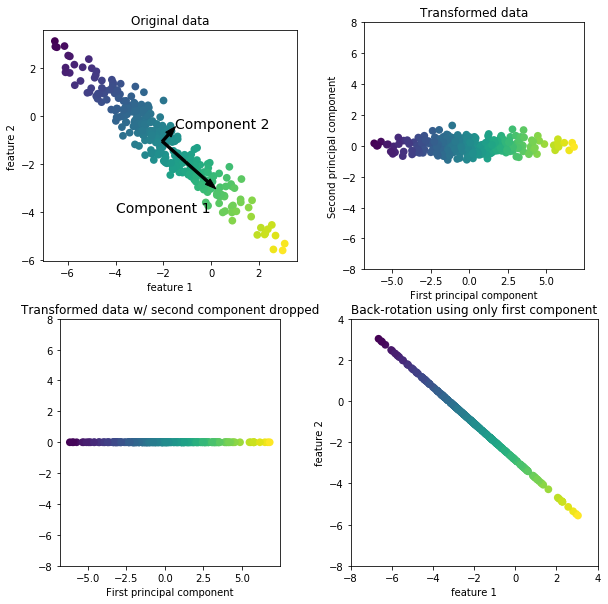

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import mglearn

mglearn.plots.plot_pca_illustration()
# plt.gcf().set_size_inches(10, 10)
plt.show()

- 第一张图(左上)显示的是原始数据，用不同颜色区分。算法首先找到方差最大的方向，将其标记为“成分1”(Component 1)。这是数据中包含最多信息的方向(或向量)，换句话说，沿着这个方向的特征之间最为相关。然后，算法找到与第一个方向正交（成直角）且包含最多信息的方向。在二维空间中，只有一个成直角的方向，但在更高维的空间中会有无穷多的正交方向。虽然这两个成分都画成箭头，但其头尾的位置并不重要。我们也可以将第一个成分画成从中心指向左上，而不是指向右下。利用这一过程找到的方向被称为主成分(principal component)，因为它们是数据方差的主要方向。一般来说，主成分的个数与原始特征相同
- 第二张图(右上)显示的是同样的数据，但现在将其旋转，使得第一主成分与x轴平行且第二主成分与y轴平行。在旋转之前，从数据中减去平均值，使得变换后的数据以零为中心。在PCA找到的旋转表示中，两个坐标轴是不相关的，也就是说，对于这种数据表示，除了对角线，相关矩阵全部为零
- 我们可以通过仅保留一部分主成分来使用PCA进行降维。在这个例子中，我们可以仅保留第一个主成分，如第三张图所示(左下)。这将数据从二维数据集降为一维数据集。但要注意，我们没有保留原始特征之一，而是找到了最有趣的方向(第一张图中从左上到右下)并保留这一方向，即第一主成分
- 最后，我们可以反向旋转并将平均值重新加到数据中。这样会得到最后一张图中的数据。这些数据点位于原始特征空间中，但我们仅保留了第一主成分中包含的信息。这种变换有时用于去除数据中的噪声影响，或者将主成分中保留的那部分信息可视化

#### 3.4.1.1 将 PCA 应用于cancer数据集并可视化
PCA最常见的应用之一就是将高维数据集可视化。对于`Iris数据集`，我们可以创建散点图矩阵(见第1章图1-3)，通过展示特征所有可能的两两组合来展示数据的局部图像。但如果要查看乳腺癌数据集，这个数据集包含30个特征，这就导致需要绘制$30 * 14 = 420$张散点图！我们永远不可能仔细观察所有这些图像，更不用说试图理解它们了。

不过我们可以使用一种更简单的可视化方法——对每个特征分别计算两个类别（良性肿瘤和恶性肿瘤）的直方图：

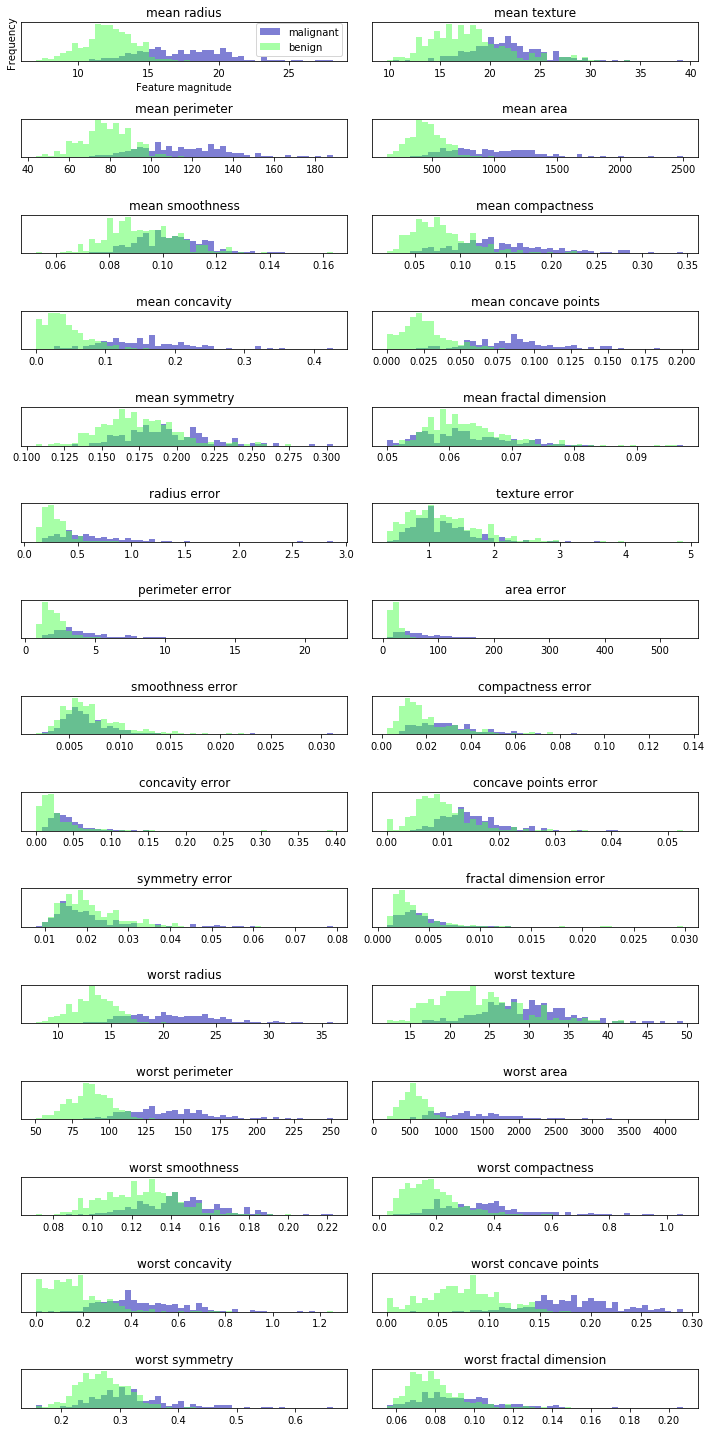

In [2]:
cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))
malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")
fig.tight_layout()
plt.show()

我们为每个特征创建一个直方图，计算具有某一特征的数据点在特定范围内的出现频率。每张图都包含两个直方图，一个是良性类别的所有点(蓝色)，一个是恶性类别的所有点(红色)。这样我们可以了解每个特征在两个类别中的分布情况，也可以猜测哪些特征能够更好地区分良性样本和恶性样本。例如，“smoothness error”特征似乎没有什么信息量，因为两个直方图大部分都重叠在一起，而“worst concave points”特征看起来信息量相当大，因为两个直方图的交集很小。

但是，这种图无法向我们展示变量之间的相互作用以及这种相互作用与类别之间的关系。利用PCA，我们可以获取到主要的相互作用，并得到稍为完整的图像。我们可以找到前两个主成分，并在这个新的二维空间中用散点图将数据可视化。

在应用PCA之前，我们利用`StandardScaler`缩放数据，使每个特征的方差均为1：

In [3]:
cancer = load_breast_cancer()

scaler = StandardScaler()
scaler.fit(cancer.data)
X_scaled = scaler.transform(cancer.data)

学习并应用`PCA`变换与应用预处理变换一样简单。我们将`PCA`对象实例化，调用`fit`方法找到主成分，然后调用`transform`来旋转并降维。默认情况下，`PCA`仅旋转(并移动)数据，但保留所有的主成分。为了降低数据的维度，我们需要在创建`PCA`对象时指定想要保留的主成分个数：

Original shape: (569, 30)
Reduced shape: (569, 2)


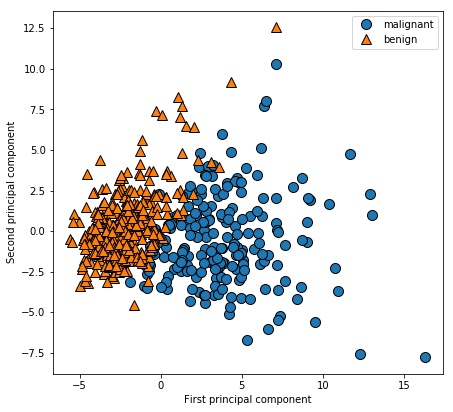

In [4]:
# 保留数据的前两个主成分
pca = PCA(n_components=2)

# 对乳腺癌数据拟合PCA模型
pca.fit(X_scaled)

# 将数据变换到前两个主成分的方向上
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

# 对第一个和第二个主成分作图，按类别着色
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.gcf().set_size_inches(7, 7)
plt.show()

`PCA`是一种无监督方法，在寻找旋转方向时没有用到任何类别信息。它只是观察数据中的相关性。对于这里所示的散点图，我们绘制了第一主成分与第二主成分的关系，然后利用类别信息对数据点进行着色。你可以看到，在这个二维空间中两个类别被很好地分离。这让我们相信，即使是线性分类器也可以表现得相当不错。我们还可以看到，恶性点比良性点更加分散，这一点也可以在之前的直方图中看出来。

`PCA`的一个缺点在于，通常不容易对图中的两个轴做出解释。主成分对应于原始数据中的方向，所以它们是原始特征的组合。但这些组合往往非常复杂，这一点我们很快就会看到。在拟合过程中，主成分被保存在`PCA`对象的`components_`属性中：

In [5]:
print("PCA component shape: {}".format(pca.components_.shape))

# components_ 中的每一行对应于一个主成分，它们按重要性排序(第一主成分排在首位，以此类推)
# 列对应于PCA的原始特征属性，在本例中即为“mean radius”、“mean texture”等
print("PCA components:\n{}".format(pca.components_))

PCA component shape: (2, 30)
PCA components:
[[ 0.21890244  0.10372458  0.22753729  0.22099499  0.14258969  0.23928535
   0.25840048  0.26085376  0.13816696  0.06436335  0.20597878  0.01742803
   0.21132592  0.20286964  0.01453145  0.17039345  0.15358979  0.1834174
   0.04249842  0.10256832  0.22799663  0.10446933  0.23663968  0.22487053
   0.12795256  0.21009588  0.22876753  0.25088597  0.12290456  0.13178394]
 [-0.23385713 -0.05970609 -0.21518136 -0.23107671  0.18611302  0.15189161
   0.06016536 -0.0347675   0.19034877  0.36657547 -0.10555215  0.08997968
  -0.08945723 -0.15229263  0.20443045  0.2327159   0.19720728  0.13032156
   0.183848    0.28009203 -0.21986638 -0.0454673  -0.19987843 -0.21935186
   0.17230435  0.14359317  0.09796411 -0.00825724  0.14188335  0.27533947]]


用热图将系数可视化更容易理解：

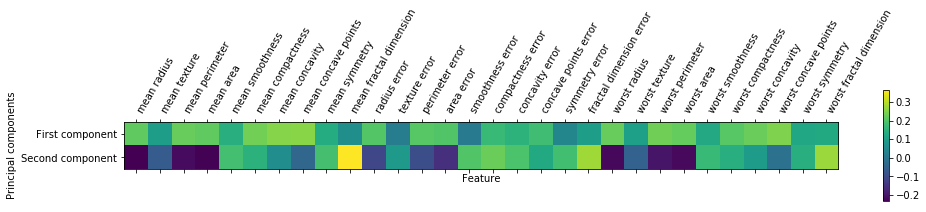

In [6]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")
plt.show()

可以看到，在第一个主成分中，所有特征的符号均为正，这意味着在所有特征之间存在普遍的相关性。如果一个测量值较大的话，其他的测量值可能也较大。第二个主成分的符号有正有负，而且两个主成分都包含所有30个特征，这种所有特征的混合使得解释图中的坐标轴变得十分困难。

#### 3.4.1.2 特征提取的特征脸
PCA的另一个应用是特征提取。特征提取背后的思想是，可以找到一种数据表示，比给定的原始表示更适合于分析。特征提取很有用，它的一个很好的应用实例就是图像。图像由像素组成，通常存储为红绿蓝（RGB）强度。图像中的对象通常由上千个像素组成，它们只有放在一起才有意义。

我们将使用`Wild数据集Labeled Faces(标记人脸)`中的人脸图像演示PCA特征提取。数据集包含从互联网下载的名人脸部图像，它包含从21世纪初开始的政治家、歌手、演员和运动员的人脸图像。我们使用这些图像的灰度版本，并将它们按比例缩小以加快处理速度。下图(`图3-7`)是其中一些图像：

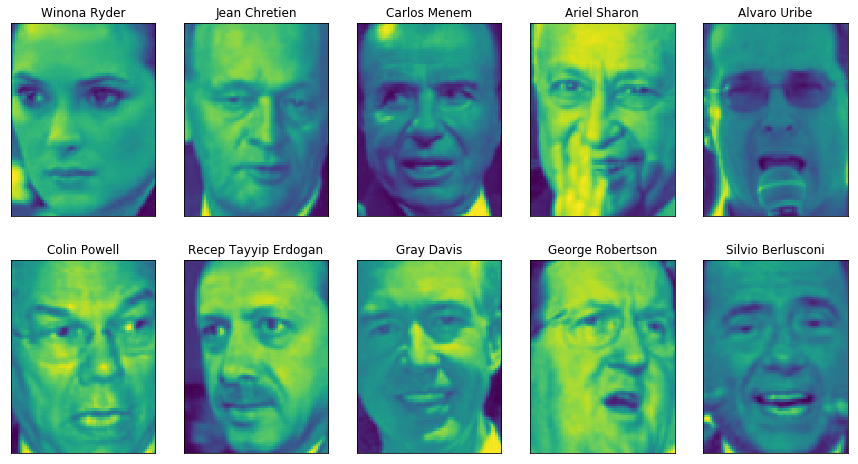

In [7]:
from sklearn.datasets import fetch_lfw_people

people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15, 8), subplot_kw={'xticks': (), 'yticks': ()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])
plt.show()

一共有$3023$张图像，每张大小为$87*65$像素，分别属于$62$个不同的人：

In [8]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classes: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classes: 62


这个数据集有些偏斜，其中包含`George W. Bush`和`Colin Powell`的大量图像：

In [9]:
# 计算每个目标出现的次数
counts = np.bincount(people.target)
# 将次数与目标名称一起打印出来
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39   Alvaro Uribe               35   Amelie Mauresmo            21   
Andre Agassi               36   Angelina Jolie             20   Ariel Sharon               77   
Arnold Schwarzenegger      42   Atal Bihari Vajpayee       24   Bill Clinton               29   
Carlos Menem               21   Colin Powell              236   David Beckham              31   
Donald Rumsfeld           121   George Robertson           22   George W Bush             530   
Gerhard Schroeder         109   Gloria Macapagal Arroyo    44   Gray Davis                 26   
Guillermo Coria            30   Hamid Karzai               22   Hans Blix                  39   
Hugo Chavez                71   Igor Ivanov                20   Jack Straw                 28   
Jacques Chirac             52   Jean Chretien              55   Jennifer Aniston           21   
Jennifer Capriati          42   Jennifer Lopez             21   Jeremy Greenstock          24   
Jiang Zemin                20 

为了降低数据偏斜，我们对每个人最多只取$50$张图像(否则，特征提取将会被`George W. Bush`的可能性大大影响：

In [10]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# 将灰度值缩放到0到1之间，而不是在0到255之间
# 以得到更好的数据稳定性
X_people = X_people / 255.

人脸识别的一个常见任务就是看某个前所未见的人脸是否属于数据库中的某个已知人物。解决这个问题的方法之一就是构建一个分类器，每个人都是一个单独的类别。但人脸数据库中通常有许多不同的人，而同一个人的图像很少(也就是说，每个类别的训练样例很少)。这使得大多数分类器的训练都很困难。另外，通常你还想要能够轻松添加新的人物，不需要重新训练一个大型模型。

一种简单的解决方法是使用$KNeighborsClassifier$，寻找与你要分类的人脸最为相似的人脸。这个分类器原则上可以处理每个类别只有一个训练样例的情况：

In [11]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# 将数据分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

# 使用一个邻居构建KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


对于包含$62$个类别的分类问题来说，结果不算太差(随机猜测的精度约为$\frac{1}{62}=1.5\%$)，但也不算好。我们每识别四次仅正确识别了一个人。

这里就可以用到PCA。***想要度量人脸的相似度，计算原始像素空间中的距离是一种相当糟糕的方法。用像素表示来比较两张图像时，我们比较的是每个像素的灰度值与另一张图像对应位置的像素灰度值。这种表示与人们对人脸图像的解释方式有很大不同，使用这种原始表示很难获取到面部特征。例如，如果使用像素距离，那么将人脸向右移动一个像素将会发生巨大的变化，得到一个完全不同的表示。我们希望，使用沿着主成分方向的距离可以提高精度。这里我们启用PCA的白化(whitening)选项，它将主成分缩放到相同的尺度。变换后的结果与使用StandardScaler相同。白化不仅对应于旋转数据，还对应于缩放数据使其形状是圆形而不是椭圆：***

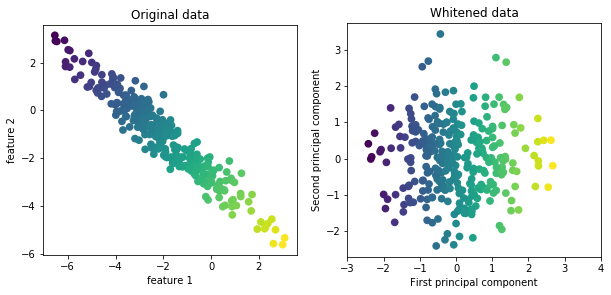

In [12]:
mglearn.plots.plot_pca_whitening()
plt.show()

我们对训练数据拟合PCA对象，并提取前100个主成分。然后对训练数据和测试数据进行变换：

In [13]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)

print("pca.components_.shape: {}".format(pca.components_.shape))
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

pca.components_.shape: (100, 5655)
Test set accuracy: 0.31


我们的精度有了相当显著的提高，这证实了我们的直觉，即主成分可能提供了一种更好的数据表示。

对于图像数据，我们还可以很容易地将找到的主成分可视化。请记住，成分对应于输入空间里的方向。这里的输入空间是$87*65$像素的灰度图像，所以在这个空间中的方向也是$87*65$像素的灰度图像(`图3-9`)：

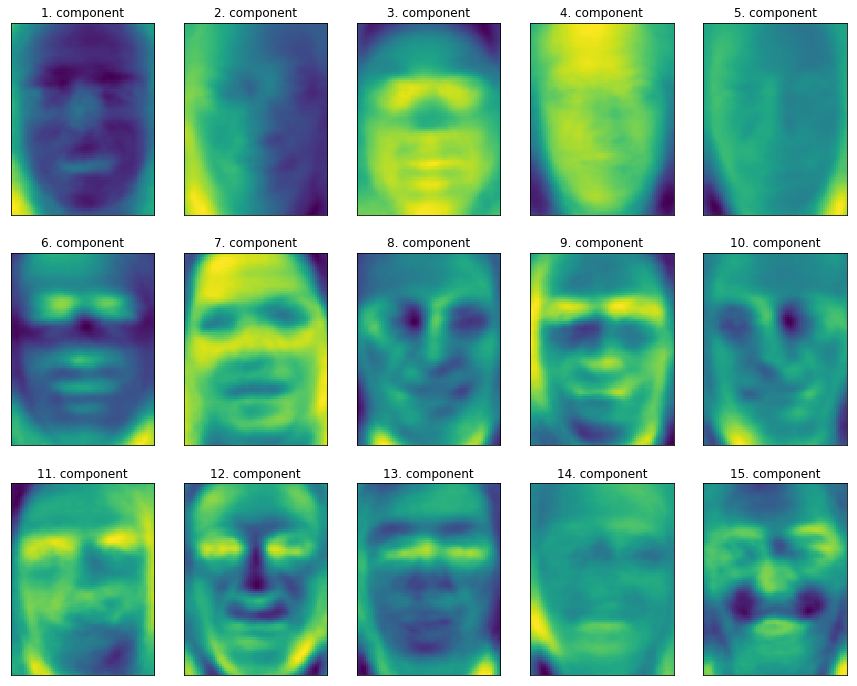

In [14]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))
plt.show()

虽然我们肯定无法理解这些成分的所有内容，但可以猜测一些主成分捕捉到了人脸图像的哪些方面。第一个主成分似乎主要编码的是人脸与背景的对比，第二个主成分编码的是人脸左半部分和右半部分的明暗程度差异，如此等等。虽然这种表示比原始像素值的语义稍强，但它仍与人们感知人脸的方式相去甚远。由于PCA模型是基于像素的，因此人脸的相对位置（眼睛、下巴和鼻子的位置）和明暗程度都对两张图像在像素表示中的相似程度有很大影响。但人脸的相对位置和明暗程度可能并不是人们首先感知的内容。在要求人们评价人脸的相似度时，他们更可能会使用年龄、性别、面部表情和发型等属性，而这些属性很难从像素强度中推断出来。重要的是要记住，算法对数据(特别是视觉数据，比如人们非常熟悉的图像)的解释通常与人类的解释方式大不相同。

不过让我们回到PCA的具体案例。我们对PCA变换的介绍是：先旋转数据，然后删除方差较小的成分。另一种有用的解释是尝试找到一些数字(PCA旋转后的新特征值)，使我们可以将测试点表示为主成分的加权求和。如下图(`图3-10`)所示，这里$x_0、x_1$等是这个数据点的主成分的系数，换句话说，它们是图像在旋转后的空间中的表示：
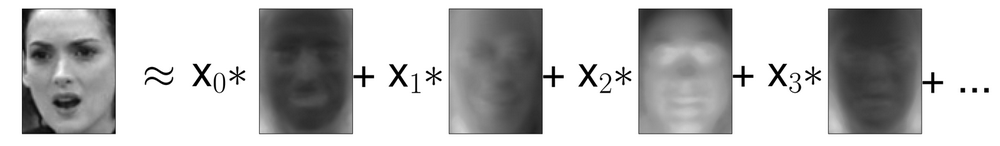

我们还可以用另一种方法来理解PCA模型，就是仅使用一些成分对原始数据进行重建。我们可以对人脸做这样的变换，将数据降维到只包含一些主成分，然后反向旋转回到原始空间。回到原始特征空间可以通过`inverse_transform`方法来实现。这里我们分别利用10个、50个、100个和500个成分对一些人脸进行重建并将其可视化(`图3-11`)：

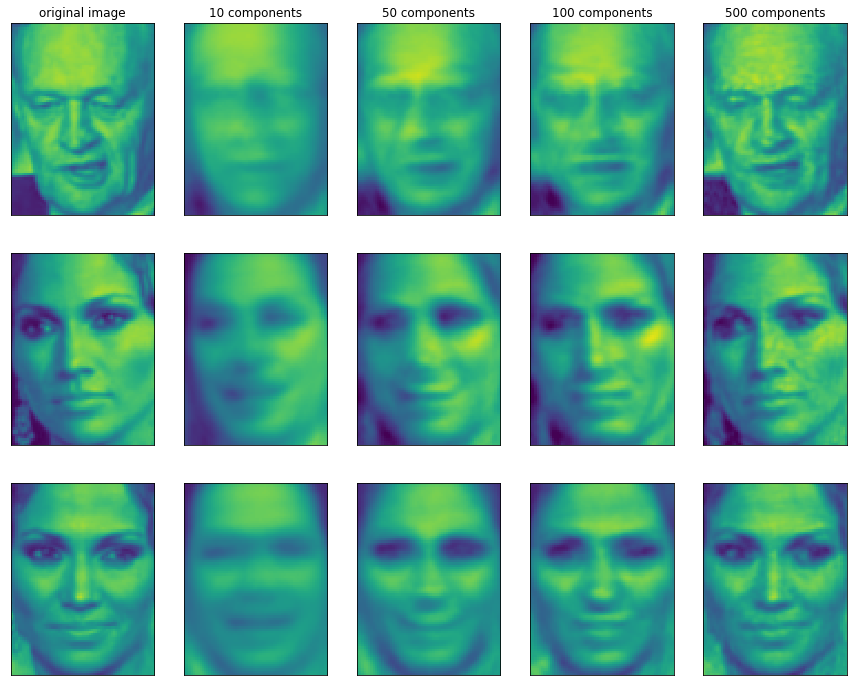

In [15]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape)
plt.show()

可以看到，在仅使用前10个主成分时，仅捕捉到了图片的基本特点，比如人脸方向和明暗程度。随着使用的主成分越来越多，图像中也保留了越来越多的细节。如果使用的成分个数与像素个数相等，意味着我们在旋转后不会丢弃任何信息，可以完美重建图像。

我们还可以尝试使用PCA的前两个主成分，将数据集中的所有人脸在散点图中可视化，其类别在图中给出。这与我们对`cancer`数据集所做的类似：

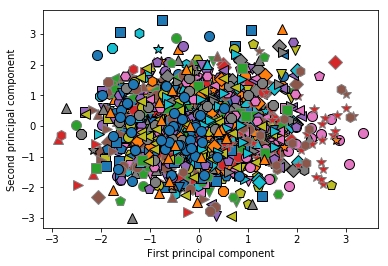

In [16]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)
plt.xlabel("First principal component")
plt.ylabel("Second principal component")
plt.show()

如你所见，如果我们只使用前两个主成分，整个数据只是一大团，看不到类别之间的分界。这并不意外，因为即使有10个成分，PCA 也仅捕捉到人脸非常粗略的特征。